# Dynamic height calculation
    - Take a T/S profile
    - Calculate absolute salinity and conservative temperature
    - Calculate dynamic height 
    - Calculate geostrophic velocity 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gsw
import cartopy.crs as ccrs
import scipy.interpolate as itp

In [2]:
# Open the cruise data file
#
# define file name
fn='../week3/33RO20161119_hy1.csv'
# read in the cruise data
df=pd.read_csv(fn,skiprows=149,header=0)
# display the first 5 rows
df.head()

,EXPOCODE,SECT_ID,STNNBR,CASTNO,SAMPNO,BTLNBR,BTLNBR_FLAG_W,DATE,TIME,LATITUDE,...,ALKALI_FLAG_W,PH_SWS,PH_SWS_FLAG_W,PH_TMP,POC,POC_FLAG_W,PON,PON_FLAG_W,SF6,SF6_FLAG_W
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,DEG C,UG/KG,NaN,UG/KG,NaN,PMOL/KG,NaN
1,33RO20161119,P18,1.0,3.0,1.0,11010.0,2.0,20161124.0,1417.0,22.6884,...,2.0,7.5127,2.0,25.00,-999.00,9.0,-999.00,9.0,0.0000,2.0
2,33RO20161119,P18,1.0,3.0,2.0,11101.0,2.0,20161124.0,1417.0,22.6884,...,2.0,7.4893,2.0,25.00,-999.00,9.0,-999.00,9.0,0.0031,2.0
3,33RO20161119,P18,1.0,3.0,3.0,11102.0,2.0,20161124.0,1417.0,22.6884,...,6.0,7.4699,2.0,25.00,-999.00,9.0,-999.00,9.0,-999.0,9.0
4,33RO20161119,P18,1.0,3.0,4.0,11103.0,2.0,20161124.0,1417.0,22.6884,...,2.0,7.4472,2.0,25.00,-999.00,9.0,-999.00,9.0,0.0112,6.0


In [3]:
# get T, S, P, LON, LAT, STNNBR
T = df['CTDTMP'][1:].to_numpy().astype(float)
S = df['CTDSAL'][1:].to_numpy().astype(float)
P = df['CTDPRS'][1:].to_numpy().astype(float)
LON = df['LONGITUDE'][1:].to_numpy().astype(float)
LAT = df['LATITUDE'][1:].to_numpy().astype(float)
STN = df['STNNBR'][1:].to_numpy().astype(float)

In [4]:
# calculate SA
SA = gsw.SA_from_SP(S,P,LON,LAT)

In [5]:
# calculate CT
CT = gsw.CT_from_t(SA,T,P)

/Users/takamitsu3/opt/anaconda3/envs/PCO_F2023/lib/python3.9/site-packages/shapely/creation.py:120: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


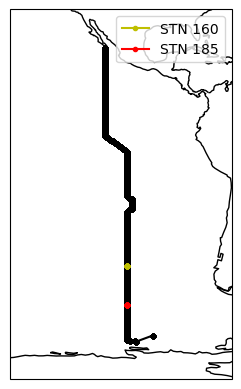

In [6]:
# plot the cruise track as in a map
ax=plt.subplot(111,projection=ccrs.PlateCarree(central_longitude=180))
#ax.set_global()
ax.set_extent([-140, -70, -80, 30])
ax.coastlines()
ax.plot(LON,LAT,'k.-',transform=ccrs.PlateCarree())
ax.plot(LON[STN==160],LAT[STN==160],'y.-',transform=ccrs.PlateCarree(),label='STN 160')
ax.plot(LON[STN==185],LAT[STN==185],'r.-',transform=ccrs.PlateCarree(),label='STN 185')
plt.legend()
plt.show()

In [7]:
# calculate dynamic height for station 160
p_ref=3000.
g=9.8
A = 160
saA = np.flip(SA[STN==A])
ctA = np.flip(CT[STN==A])
pA = np.flip(P[STN==A])
#
ZA = gsw.geo_strf_dyn_height(saA,ctA,pA,p_ref)/g
#
print(f'Station {A} is at LON={LON[STN==A][0]}, LAT={LAT[STN==A][0]}')

Station 160 is at LON=-103.0001, LAT=-46.0001


In [8]:
# calculate dynamic height for station 185
p_ref=3000.
B = 185
saB = np.flip(SA[STN==B])
ctB = np.flip(CT[STN==B])
pB = np.flip(P[STN==B])
#
ZB = gsw.geo_strf_dyn_height(saB,ctB,pB,p_ref)/g
#
print(f'Station {B} is at LON={LON[STN==B][0]}, LAT={LAT[STN==B][0]}')

Station 185 is at LON=-102.9976, LAT=-58.5017


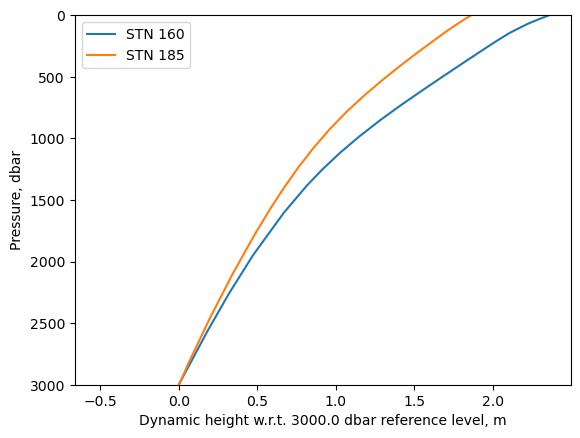

In [9]:
plt.plot(ZA,pA,label=f'STN {A}')
plt.plot(ZB,pB,label=f'STN {B}')
plt.ylim(3000,0)
plt.legend()
plt.xlabel(f'Dynamic height w.r.t. {p_ref} dbar reference level, m')
plt.ylabel('Pressure, dbar')
plt.show()

## Geostrophic calculation
    - u = - g/f dZ/dy
    - Vertically intepolate dynamic height, Z, for standard depths
    - Approximate f, dZ/dy for the two stations

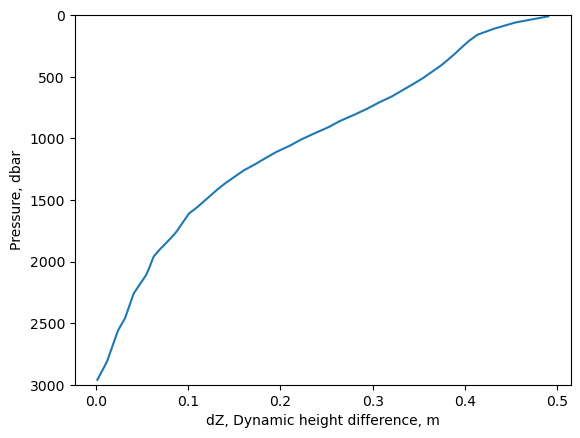

In [10]:
pstd = np.arange(10,3010,50)
ZAitp = itp.interp1d(pA,ZA)
ZBitp = itp.interp1d(pB,ZB)
dZ = ZAitp(pstd) - ZBitp(pstd)
# plot dZ as a function of pressure
plt.plot(dZ,pstd)
plt.xlabel(f'dZ, Dynamic height difference, m')
plt.ylabel('Pressure, dbar')
plt.ylim(3000,0)
plt.show()

In [11]:
latA = LAT[STN==A][0]
latB = LAT[STN==B][0]
#
meanLAT = (latA+latB)/2
#
Omega = 2*np.pi/(60*60*24)
f = 2*Omega*np.sin(np.pi/180*meanLAT)
#
print(f'Coriolis parameter = {f:.3}')

Coriolis parameter = -0.000115


In [12]:
# distance in y
R = 6.37e6
dy = R*np.pi/180*(latA-latB)
print(f'Distance between the two stations is {dy:.3}, m')

Distance between the two stations is 1.39e+06, m


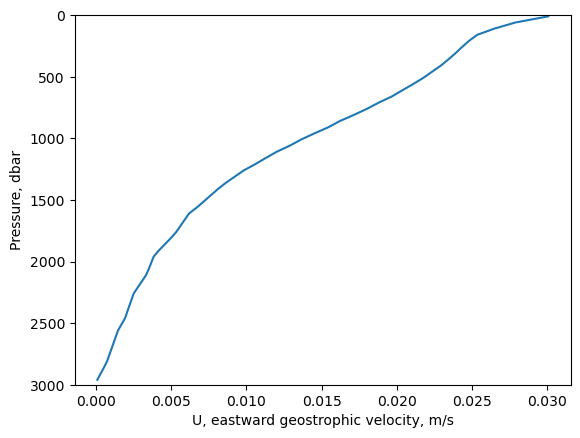

In [13]:
# calculate U
U = -9.8/f*dZ/dy
# plot dZ as a function of pressure
plt.plot(U,pstd)
plt.xlabel(f'U, eastward geostrophic velocity, m/s')
plt.ylabel('Pressure, dbar')
plt.ylim(3000,0)
plt.show()